# Import Libaries

In [11]:
from os import listdir
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import stats
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, losses
from sklearn.metrics import confusion_matrix
import seaborn as sn

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

In [12]:
# Print versions
!python --version
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

Python 3.7.12
Numpy 1.19.5
TensorFlow 2.7.0
Keras 2.7.0


# Settings

In [13]:
# Settings
dataset_path = 'dataset'  # Directory where raw accelerometer data is stored
normal_op_list = ['train'] #['fan_0_low_0_weight']

val_ratio = 0.2             # Percentage of samples that should be held for validation set
test_ratio = 0.2            # Percentage of samples that should be held for test set

sensor_sample_rate = 200    # Hz
desired_sample_rate = 50    # Hz
sample_time =2           # Time (sec) length of each sample
samples_per_file = 400      # Expected number of measurements in each file (truncate to this)
max_measurements = int(sample_time * sensor_sample_rate)
downsample_factor = int(samples_per_file / desired_sample_rate)
win_len = int(max_measurements / downsample_factor)

keras_model_name = 'encoder_model'           # Will be given .h5 suffix
sample_file_name = '../test_samples/normal_anomaly_samples'  # Will be given .npz suffix
rep_dataset_name = '../test_samples/normal_anomaly_test_set' # Will be given .npz suffix

print('Max measurements per file:', max_measurements)
print('Downsample factor:', downsample_factor)
print('Window length:', win_len)

Max measurements per file: 400
Downsample factor: 8
Window length: 50


# Parse the data from CSV

In [4]:
# Create list of filenames
def createFilenameList(op_list):
    
    # Extract paths and filenames in each directory
    op_filenames = []
    num_samples = 0
    for index, target in enumerate(op_list):
        samples_in_dir = listdir(join(dataset_path, target))
        samples_in_dir = [join(dataset_path, target, sample) for sample in samples_in_dir]
        op_filenames.append(samples_in_dir)
    
    # Flatten list
    return [item for sublist in op_filenames for item in sublist]

In [14]:
# Create normal and anomaly filename lists
normal_op_filenames = createFilenameList(normal_op_list)
print('Number of normal samples:', len(normal_op_filenames))


Number of normal samples: 201


In [16]:
# Shuffle lists
random.shuffle(normal_op_filenames)


In [17]:
# Calculate validation and test set sizes
val_set_size = int(len(normal_op_filenames) * val_ratio)
test_set_size = int(len(normal_op_filenames) * test_ratio)

In [18]:
# Break dataset apart into train, validation, and test sets
num_samples = len(normal_op_filenames)

In [19]:
accX = []
accY = []
accZ = []
for x in range(0, num_samples):
  sample = np.genfromtxt(normal_op_filenames[x], delimiter=',')
  sample_t = sample.T
  accX.append(sample_t[0])
  accY.append(sample_t[1])
  accZ.append(sample_t[2])


In [20]:
data_raw = np.dstack((accX, accY, accZ))

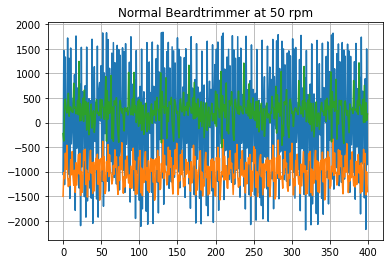

In [21]:
plt.grid()
plt.plot(np.arange(max_measurements), data_raw[0,:,0])
plt.plot(np.arange(max_measurements), data_raw[0,:,1])
plt.plot(np.arange(max_measurements), data_raw[0,:,2])
plt.title("Normal Beardtrimmer at 50 rpm")
plt.show()

In [22]:
print(data_raw[0].shape)

(400, 3)


## Reduce data dimension using PCA

In [23]:
# Reducing dimensions using PCA
from sklearn.decomposition import PCA

In [24]:
# A test
pca = PCA(n_components=1)
data_pca = pca.fit_transform(data_raw[0])

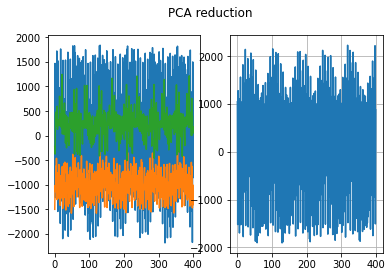

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('PCA reduction')
plt.grid()
ax1.plot(np.arange(max_measurements), data_raw[0,:,0])
ax1.plot(np.arange(max_measurements), data_raw[0,:,1])
ax1.plot(np.arange(max_measurements), data_raw[0,:,2])
ax2.plot(np.arange(max_measurements), data_pca)
plt.show()

In [26]:
# Reducing data to one dimension using PCA
def extract_pca(data,num_samples):
  data_pca = np.zeros([num_samples, max_measurements], dtype = np.float )
  pca_ = PCA(n_components=1)
  for x in range(0,num_samples):  
    data_pca[x] = pca.fit_transform(data[x]).flatten()
  return data_pca

In [27]:
data = extract_pca(data_raw,num_samples)
print(data.shape)

(201, 400)


# Train

In [28]:
data_val = data[:val_set_size]
data_test = data[val_set_size:(val_set_size + test_set_size)]
data_train = data[(val_set_size + test_set_size):]

# Print out number of samples in each set
print('Number of training samples:', len(data_train))
print('Number of validation samples:', len(data_val))
print('Number of test samples:', len(data_test))

# Check that our splits add up correctly
assert(len(data_train) + len(data_val) + len(data_test)) == num_samples

Number of training samples: 121
Number of validation samples: 40
Number of test samples: 40


### Load anomalities

In [31]:
anomality_list = ['anomalities'] 

In [32]:
anomality_filenames = createFilenameList(anomality_list)
anomality_num_samples =  len(anomality_filenames)
print('Number of normal samples:',anomality_num_samples )

Number of normal samples: 11


In [33]:
accX = []
accY = []
accZ = []
for x in range(0, anomality_num_samples):
  sample = np.genfromtxt(anomality_filenames[x], delimiter=',')
  sample_t = sample.T
  accX.append(sample_t[0])
  accY.append(sample_t[1])
  accZ.append(sample_t[2])

In [34]:
anomality_raw = np.dstack((accX, accY, accZ))

In [35]:
anomality_data = extract_pca(anomality_raw, anomality_num_samples)
print(anomality_data.shape)

(11, 400)


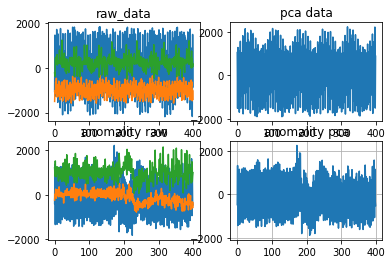

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
plt.grid()
ax1.plot(np.arange(max_measurements), data_raw[0,:,0])
ax1.plot(np.arange(max_measurements), data_raw[0,:,1])
ax1.plot(np.arange(max_measurements), data_raw[0,:,2])
ax1.set_title('raw_data')
ax2.plot(np.arange(max_measurements), data_pca)
ax2.set_title('pca data')
ax3.plot(np.arange(max_measurements), anomality_raw[0,:,0])
ax3.plot(np.arange(max_measurements), anomality_raw[0,:,1])
ax3.plot(np.arange(max_measurements), anomality_raw[0,:,2])
ax3.set_title('anomality raw')
ax4.plot(np.arange(max_measurements), anomality_data[0])
ax4.set_title('anomality pca')
plt.show()

### Data normalization between [0,1]

In [37]:
# Normalize values
min_val = tf.reduce_min(np.concatenate((data, anomality_data), axis=None))
max_val = tf.reduce_max(np.concatenate((data, anomality_data), axis=None))

min_val = tf.cast(min_val, tf.float32)
max_val = tf.cast(max_val, tf.float32)

data_train = (data_train - min_val) / (max_val - min_val)
data_train = tf.cast(data_train, tf.float32)

data_val = (data_val - min_val) / (max_val - min_val)
data_val = tf.cast(data_val, tf.float32)

data_test = (data_test - min_val) / (max_val - min_val)
data_test = tf.cast(data_test, tf.float32)

anomality = (anomality_data - min_val) / (max_val - min_val)
anomality = tf.cast(anomality, tf.float32)

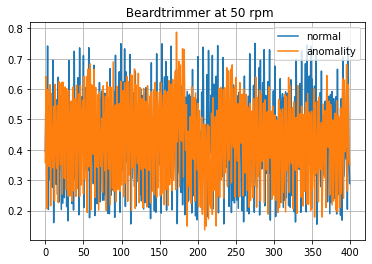

In [38]:
plt.grid()
plt.plot(np.arange(max_measurements), data_train[0], label='normal')
plt.plot(np.arange(max_measurements), anomality[0], label='anomality')
plt.title(" Beardtrimmer at 50 rpm")
plt.legend()
plt.show()

### Model creation

In [43]:
ae_model = tf.keras.Sequential([
                  #              layers.Dense(256, activation='relu'),
                                layers.Dense(128, activation='relu'),
                                layers.Dense(64, activation='relu'),
                                layers.Dense(32, activation='relu'),
                                layers.Dense(8, activation='relu'),
                                layers.Dense(32, activation='relu'),
                                layers.Dense(64, activation='relu'),
                                layers.Dense(128, activation='relu'),
                  #              layers.Dense(256, activation='relu'),
                                layers.Dense(400, activation='sigmoid')
])

ae_model.compile(optimizer='adam', loss='mae')

In [44]:
history = ae_model.fit(data_train, data_train, 
          epochs=100, 
          batch_size=100,
          validation_data=(data_val, data_val),
          shuffle=True)

Epoch 1/100
2/2 [==============================] - 1s 165ms/step - loss: 0.1624 - val_loss: 0.1627
Epoch 2/100
2/2 [==============================] - 0s 31ms/step - loss: 0.1623 - val_loss: 0.1626
Epoch 3/100
2/2 [==============================] - 0s 29ms/step - loss: 0.1621 - val_loss: 0.1624
Epoch 4/100
2/2 [==============================] - 0s 31ms/step - loss: 0.1618 - val_loss: 0.1620
Epoch 5/100
2/2 [==============================] - 0s 26ms/step - loss: 0.1613 - val_loss: 0.1615
Epoch 6/100
2/2 [==============================] - 0s 29ms/step - loss: 0.1606 - val_loss: 0.1607
Epoch 7/100
2/2 [==============================] - 0s 26ms/step - loss: 0.1596 - val_loss: 0.1600
Epoch 8/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1584 - val_loss: 0.1594
Epoch 9/100
2/2 [==============================] - 0s 34ms/step - loss: 0.1573 - val_loss: 0.1587
Epoch 10/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1561 - val_loss: 0.1577
Epoch 11/100
2/2 [

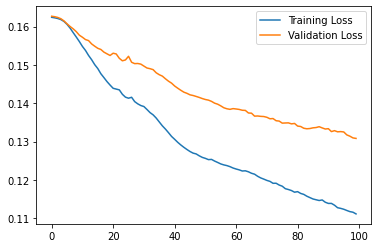

In [45]:
# Plot results
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Training Results

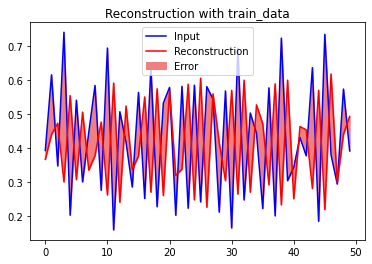

In [46]:
decoded_imgs  = ae_model(data_train).numpy()
samples_plot = 50
data_plot = data_train[0,0:samples_plot]

plt.plot(data_plot,'b')
plt.plot(decoded_imgs[0,0:samples_plot],'r')
plt.fill_between(np.arange(50), decoded_imgs[0,0:samples_plot], data_plot, color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title('Reconstruction with train_data')
plt.show()

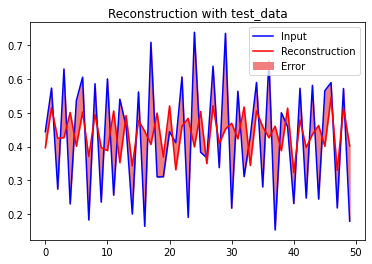

In [47]:
decoded_imgs  = ae_model(data_test).numpy()
samples_plot = 50
data_plot = data_test[0,0:samples_plot]

plt.plot(data_plot,'b')
plt.plot(decoded_imgs[0,0:samples_plot],'r')
plt.fill_between(np.arange(50), decoded_imgs[0,0:samples_plot], data_plot, color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title('Reconstruction with test_data')
plt.show()

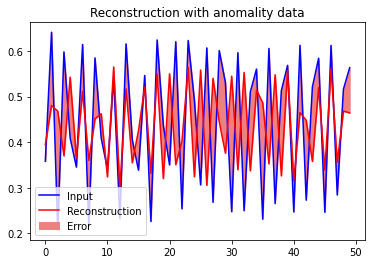

In [48]:
decoded_imgs  = ae_model(anomality).numpy()
samples_plot = 50
data_plot = anomality[0,0:samples_plot]

plt.plot(data_plot,'b')
plt.plot(decoded_imgs[0,0:samples_plot],'r')
plt.fill_between(np.arange(50), decoded_imgs[0,0:samples_plot], data_plot, color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title('Reconstruction with anomality data')
plt.show()

# Detect Anomalities

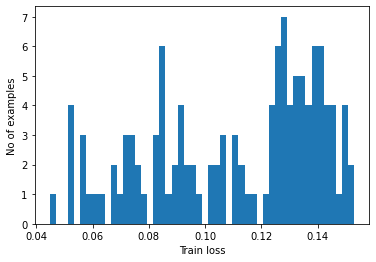

In [49]:
reconstructions = ae_model.predict(data_train)
train_loss = tf.keras.losses.mae(reconstructions, data_train)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [50]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.14067855


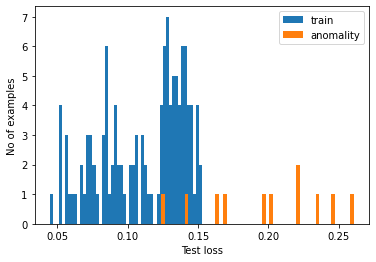

In [51]:
reconstructions = ae_model.predict(anomality)
anomality_loss = tf.keras.losses.mae(reconstructions, anomality)
plt.hist(train_loss, bins=50, label='train')
plt.hist(anomality_loss, bins=50, label='anomality')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.legend()
plt.show()

# Save model

In [53]:
# If we're happy with the performance, save the model
ae_model.save(keras_model_name + '.h5')

### Convert Keras to tflite model

In [65]:
%tensorflow_version 1.x
import tensorflow as tf
!wget https://github.com/tensorflow/tensorflow/archive/v2.4.1.zip
!unzip v2.4.1.zip &> 0
!mv tensorflow-2.4.1/ tensorflow/

TensorFlow is already loaded. Please restart the runtime to change versions.
--2022-01-07 17:19:32--  https://github.com/tensorflow/tensorflow/archive/v2.4.1.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tensorflow/tensorflow/zip/v2.4.1 [following]
--2022-01-07 17:19:32--  https://codeload.github.com/tensorflow/tensorflow/zip/v2.4.1
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v2.4.1.zip’

v2.4.1.zip              [ <=>                ]  66.13M  10.6MB/s    in 7.1s    

2022-01-07 17:19:39 (9.28 MB/s) - ‘v2.4.1.zip’ saved [69346072]



In [172]:
FLOAT_MODEL_TFLITE = 'encoder_model.tflite'
MODEL_TFLITE = 'encoder_model_int32.tflite'
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(ae_model)
tflite_model = converter.convert()
# Save the model to disk
#open("encoder_model.tflite", "wb").write(tflite_model)
float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(tflite_model)
print("Float model is %d bytes" % float_tflite_model_size)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(ae_model)
# Indicate that we want to perform the default optimizations,
# which include quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.inference_input_type = tf.lite.constants.INT8
converter.inference_input_type = tf.compat.v1.lite.constants.INT8 #replaces the above line for use with TF2.x   
#converter.inference_output_type = tf.lite.constants.INT8
converter.inference_output_type = tf.compat.v1.lite.constants.INT8 #replaces the above line for use with TF2.x

# Define a generator function that provides our test data's x values
# as a representative dataset, and tell the converter to use it
def representative_dataset_generator():
  for value in data_test:
  # Each scalar value must be inside of a 2D array that is wrapped in a list
    yield [np.array(value, dtype=np.float32, ndmin=2)]
converter.representative_dataset = representative_dataset_generator
# Convert the model
tflite_model = converter.convert()
# Save the model to disk
tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)


INFO:tensorflow:Assets written to: /tmp/tmpds4j5iu8/assets


INFO:tensorflow:Assets written to: /tmp/tmpds4j5iu8/assets


Float model is 500680 bytes
INFO:tensorflow:Assets written to: /tmp/tmp_p_stuhe/assets


INFO:tensorflow:Assets written to: /tmp/tmp_p_stuhe/assets


Quantized model is 131384 bytes


### Testing after quantization

In [127]:
from sklearn.metrics import mean_absolute_error

In [184]:
# Helper function to run inference
def run_tflite_inference_testSet(tflite_model_path, model_type="Float"):
  #
  # Load test data
  #
  np.random.seed(0) # set random seed for reproducible test results.

  #
  # Initialize the interpreter
  #
  interpreter = tf.lite.Interpreter(tflite_model_path)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]
  
  print(input_details)
  print(output_details)
  test_data  = anomality
  # need this line because test_data is [400] but the interpreter expects [1,400]
  test_data = np.expand_dims(test_data, axis=1).astype(np.float32) 

  #
  # For quantized models, manually quantize the input data from float to integer
  #
  if model_type == "Quantized":
    input_scale, input_zero_point = input_details["quantization"]
    test_data = test_data / input_scale + input_zero_point
    test_data = test_data.astype(input_details["dtype"])

  # Evaluate the predictions
  correct_predictions = 0
  for i in range(len(test_data)):
    interpreter.set_tensor(input_details["index"], test_data[i])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    #top_prediction = output.argmax()
    output = np.expand_dims(output, axis=1).astype(np.float32) 
    output = output.T
   # print("output:")
    #print(output)
    #print('test data')
    #print(test_data[i])
    correct_predictions += (mean_absolute_error(output, test_data[i])  >= threshold )
    #correct_predictions += tf.keras.losses.mae(top_prediction, test_data[i]) <= threshold
    # correct_predictions += (top_prediction == test_data[i])

  print('%s model accuracy is %f%% (Number of test samples=%d)' % (
      model_type, (correct_predictions * 100) / len(test_data), len(test_data)))

In [185]:
# Compute float model accuracy
run_tflite_inference_testSet(FLOAT_MODEL_TFLITE)

# Compute quantized model accuracy
run_tflite_inference_testSet(MODEL_TFLITE, model_type='Quantized')

{'name': 'serving_default_dense_6_input:0', 'index': 0, 'shape': array([  1, 400], dtype=int32), 'shape_signature': array([ -1, 400], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 25, 'shape': array([  1, 400], dtype=int32), 'shape_signature': array([ -1, 400], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Float model accuracy is 90.909091% (Number of test samples=11)
{'name': 'serving_default_dense_6_input:0', 'index': 0, 'shape': array([  1, 400], dtype=int32), 'shape_signature': array([ -1, 400], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00301562272943

### Generate a TensorFlow Lite for Microcontrollers Model
To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on Arduino we simply need to use the xxd tool to convert the .tflite file into a .cc file (just like we did in the pervious section).

In [79]:
!apt install xxd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xxd
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 49.6 kB of archives.
After this operation, 201 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xxd amd64 2:8.0.1453-1ubuntu1.7 [49.6 kB]
Fetched 49.6 kB in 0s (112 kB/s)
Selecting previously unselected package xxd.
(Reading database ... 155225 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.7_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.7) ...
Setting up xxd (2:8.0.1453-1ubuntu1.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [88]:
MODEL_TFLITE_MICRO = 'encoder_model_int32.cc'

In [91]:
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/autoencoder_model/g' {MODEL_TFLITE_MICRO}

That's it! You've successfully converted your TensorFlow Lite model into a TensorFlow Lite for Microcontrollers model! Run the cell below to print out its contents which we'll need for our next step, deploying the model using the Arudino IDE!

In [90]:
!cat {MODEL_TFLITE_MICRO}

unsigned char autoencoder_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0x80, 0x01, 0x00, 0x00,
  0x28, 0x00, 0x00, 0x00, 0x28, 0x01, 0x00, 0x00, 0x9c, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x2c, 0x0b, 0x00, 0x00, 0x38, 0x0a, 0x00, 0x00,
  0x14, 0x03, 0x00, 0x00, 0x7c, 0x02, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x7c, 0x01, 0x00, 0x00, 0x1e, 0x00, 0x00, 0x00, 0x38, 0x02, 0x02, 0x00,
  0x34, 0x02, 0x02, 0x00, 0x30, 0x39, 0x01, 0x00, 0xc0, 0x36, 0x01, 0x00,
  0x4c, 0x16, 0x01, 0x00, 0xe8, 0x14, 0x01, 0x00, 0x74, 0x0c, 0x01, 0x00,
  0x90, 0x0b, 0x01, 0x00, 0x1c, 0x0a, 0x01, 0x00, 0x98, 0x09, 0x01, 0x00,
  0x20, 0x08, 0x01, 0x00, 0x38, 0x07, 0x01, 0x00, 0xc0, 0xfe, 0x00, 0x00,
  0x58, 0xfd, 0x00, 0x00, 0xe0, 0xdc, 0x00, 0x00, 0x78, 0xda, 0x00, 0x00,


### More code

In [ ]:
# Save a normal and anomaly sample for trying out on the MCU
normal_sample = np.genfromtxt(filenames_test[0], delimiter=',')
anomaly_sample = np.genfromtxt(anomaly_op_filenames[0], delimiter=',')
np.savez(sample_file_name + '.npz', normal_sample=normal_sample, anomaly_sample=anomaly_sample)

In [ ]:
# Save the test dataset for use as a representative dataset
np.savez(rep_dataset_name + '.npz', x_test=x_test)

In [ ]:
# Create a classifier (0 = normal, 1 = anomaly)
def detect_anomaly(x, model, threshold=0):
    input_tensor = x_test[0].reshape(1, -1)
    pred = model.predict(input_tensor)
    mse = np.mean(np.power(x - pred, 2), axis=1)
    if mse > threshold:
        return 1
    else:
        return 0

In [ ]:
# Choose a threshold
anomaly_threshold = 3e-05

In [ ]:
# Perform classification on test set
pred_test = [detect_anomaly(x, model, anomaly_threshold) for x in x_test]
print(pred_test)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [ ]:
# Perform classification on anomaly set
pred_anomaly = [detect_anomaly(x, model, anomaly_threshold) for x in anomaly_features]
print(pred_anomaly)

[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1]


In [ ]:
# Combine predictions into one long list and create a label list
pred = np.array(pred_test + pred_anomaly)
labels = ([0] * len(pred_test)) + ([1] * len(pred_anomaly))

In [ ]:
# Create confusion matrix
cm = confusion_matrix(labels, pred)
print(cm)

[[50  9]
 [12 47]]


In [ ]:
# Make confusion matrix pretty
df_cm = pd.DataFrame(cm, index=['normal', 'anomaly'], columns=['normal', 'anomaly'])
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')

NameError: ignored